In [1]:
import pandas as pd
from trueskill import Rating, quality_1vs1, rate_1vs1, quality, rate, global_env, choose_backend,  backends, setup
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from IPython.display import display
from ipywidgets import widgets
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#!pip install --upgrade pip
#!pip install ipywidgets

In [3]:
df = pd.read_csv('Data/Competition.csv').drop_duplicates()
df

,division,compID,location,date,college,first_name,last_name,position,result,score
0,DII,790,"Huntington Beach, Ca",2018-02-15,Concordia,Kersti,Whitney,1,1,"15-21, 24-22, 15-13"
1,DII,790,"Huntington Beach, Ca",2018-02-15,Concordia,Avery,Keathley,1,1,"15-21, 24-22, 15-13"
2,NAIA,790,"Huntington Beach, Ca",2018-02-15,Vanguard,Kayla,Tinker,1,0,"15-21, 24-22, 15-13"
3,NAIA,790,"Huntington Beach, Ca",2018-02-15,Vanguard,Gabby,Morrison,1,0,"15-21, 24-22, 15-13"
4,DII,790,"Huntington Beach, Ca",2018-02-15,Concordia,Vanessa,Bernzen,2,1,"14-21, 21-19, 15-13"
5,DII,790,"Huntington Beach, Ca",2018-02-15,Concordia,Tristan,Self,2,1,"14-21, 21-19, 15-13"
6,NAIA,790,"Huntington Beach, Ca",2018-02-15,Vanguard,Hannah,Holder,2,0,"14-21, 21-19, 15-13"
7,NAIA,790,"Huntington Beach, Ca",2018-02-15,Vanguard,Kelli,Dowell,2,0,"14-21, 21-19, 15-13"
8,DII,790,"Huntington Beach, Ca",2018-02-15,Concordia,Kyra,Auten,3,1,"21-13, 21-13"
9,DII,790,"Huntington Beach, Ca",2018-02-15,Concordia,Marcela,Frazzoni,3,1,"21-13, 21-13"


In [4]:
sort_order = ['date', 'compID', 'position', 'result','last_name', 'first_name']

In [5]:
def get_competition_info(df, div):  
    df = get_teams_by_division(df, div)                                                      ## Get D1 Teams
    df = strip_all_strings_in_df(df, ['first_name', 'last_name', 'college', 'location', 'division', 'score'])     ##strip whitespace
    df = df.groupby('compID').filter(lambda x: len(x) == 20)                                 ## Remove matches against community colleges                                                 ## set default player rating
    return df.sort_values(['date', 'compID', 'position', 'result'], ascending=True).reset_index().iloc[:,1:]

def get_teams_by_division(df, div):
    df = df[df["division"] == div] \
                    .drop_duplicates() \
                    .reset_index() \
                    .iloc[:,1:]
    return df.sort_values(sort_order, ascending=True)

def strip_all_strings_in_df(df, cols):
    for s in cols:
        df[s] = df[s].apply(lambda x: x.strip())
    return df

def set_player_ratings_after_match(df,i, new):
    idx = df_player[(df_player.first_name == df.iloc[i, 0]) \
                 & (df_player.last_name == df.iloc[i, 1]) \
                 & (df_player.college == df.iloc[i, 2])].index
    df_player.loc[idx, 'rating'] = new
    return None

In [6]:
df_matches = get_competition_info(df, 'DI')

In [7]:
def set_default_player_rating(df_match_, division='DI'): 
    df_players_ = df_match_.loc[:, ['division',  'college', 'first_name', 'last_name', 'mu', 'sigma']].copy()
    df_players_ = strip_all_strings_in_df(df_players_, ['division',  'college', 'first_name', 'last_name'])
    df_players_ = df_players_.drop_duplicates()
    df_players_ = df_players_[df_players_.division == division]
    df_players_['mu'] = Rating().mu
    df_players_['sigma'] = Rating().sigma
    df_players_ = df_players_.sort_values(['last_name', 'first_name', 'college'], ascending=True)
    df_players_ = df_players_.reset_index()
    df_players_ = df_players_.loc[:, ['division',  'college', 'first_name', 'last_name',  'mu', 'sigma']]
    return df_players_

df_players = set_default_player_rating(df, 'DI')
df_players.head(5)

/usr/local/anaconda3/envs/Conda3/lib/python2.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,division,college,first_name,last_name,mu,sigma
0,DI,Jacksonville,Forfeit,1,25.0,8.333333
1,DI,Santa Clara,Forfeit,1,25.0,8.333333
2,DI,Jacksonville,Forfeit,2,25.0,8.333333
3,DI,Santa Clara,Forfeit,2,25.0,8.333333
4,DI,Long Beach State,Kristyna,Adamcikova,25.0,8.333333


In [8]:
def get_player_ratings_from_match(df_players_, fname, lname, college):
    idx = df_players_[(df_players_.first_name == fname) \
                 & (df_players_.last_name == lname) \
                 & (df_players_.college == college)].index
    my_mu = df_players_.iloc[idx.item(),  df_players_.columns.get_loc('mu')]
    my_sigma = df_players_.iloc[idx.item(),  df_players_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating

def set_player_ratings_after_match(df_players_, fname, lname, college, position, rating_):
    idx = df_players_[(df_players_.first_name == fname) \
                 & (df_players_.last_name == lname) \
                 & (df_players_.college == college)].index
    df_players_.iloc[idx,  df_players_.columns.get_loc('mu')] = rating_.mu + position_factor[int(position)-1]
    df_players_.iloc[idx,  df_players_.columns.get_loc('sigma')] = rating_.sigma
    
    my_mu = df_players_.iloc[idx.item(),  df_players_.columns.get_loc('mu')]
    my_sigma = df_players_.iloc[idx.item(),  df_players_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    
    return my_rating


def create_ratings_from_matches(df, k_factor):
    df_matches = get_competition_info(df, 'DI')
    df_players = set_default_player_rating(df, 'DI')

    groups = df_matches.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        r = {}
        r_new = {}
        for i in range(len(value)):
            fname = df_matches.iloc[value[i], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[i], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[i], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[i], df_matches.columns.get_loc('position')]
            r[i] = get_player_ratings_from_match(df_players, fname, lname, college)

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        ((r_new[0], r_new[1]), (r_new[2], r_new[3])) = rate([t1,t2], ranks=[1,0])


        for j in range(4):
            fname = df_matches.iloc[value[j], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[j], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[j], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[j], df_matches.columns.get_loc('position')]
            set_player_ratings_after_match(df_players, fname, lname, college,  position, Rating(mu=(r_new[j].mu +k_factor[i]), sigma=r_new[j].sigma  )) 

        hist_dict[counter] = df_matches.iloc[value].merge(df_players, \
                                                          left_on=['first_name', 'last_name', 'college'], 
                                                          right_on=['first_name', 'last_name', 'college'], 
                                                          how='inner')
        counter += 1

    df_match_history = pd.concat(hist_dict.values(), axis=0)
    df_match_history.sort_values(['date','compID'], ascending=True)
    df_match_history = df_match_history.iloc[:,1:]
    
    df_match_history['name'] = df_match_history['first_name'] + " " + df_match_history['last_name']
    df_match_history = df_match_history.reset_index().iloc[:,1:]
    df_match_history.rename(columns={'division_y': 'division'}, inplace=True)
    
    return df_match_history

def plot_rating_distribution(df_):
    d = df_ \
    .sort_values('date', ascending=True) \
    .groupby(['first_name', 'last_name', 'college']) \
    .last() \
    .sort_values('mu', ascending=False) \
    .reset_index()

    current_palette = sns.color_palette()
    #sns.palplot(current_palette)
    
    f =  plt.figure(figsize=(30, 15))
    grid = plt.GridSpec(3, 5, wspace=.4, hspace=0.3)
    summary_ax = f.add_subplot(grid[:2, 0:])
    pos_ax = [f.add_subplot(grid[2, 4+(i*-1)], xticklabels=[], sharey=summary_ax) for i in range(5)]

    [sns.distplot( d[d.position==i+1]['mu'], ax=summary_ax,  color=current_palette[i], axlabel='Rating', hist_kws=dict(alpha=.1)) for i in range(5)]
    #summary_ax.plot([0, 0], [.05, 50], linewidth=2)
    
    [sns.distplot( d[d.position==i+1]['mu'], ax=pos_ax[i], color=current_palette[i], axlabel='Position '+str(i+1))  for i in range(5)]
    return d

def get_top_players(df, position='all'):
    if position == 'all':
        df_all_positions = df.sort_values(['date', 'compID'], ascending=True) \
            .groupby(['first_name', 'last_name', 'college']) \
            .last() \
            .sort_values('mu', ascending=False) \
            .reset_index()
    else:
        df_all_positions = df[df.position == position].sort_values(['date', 'compID'], ascending=True) \
            .groupby(['first_name', 'last_name', 'college']) \
            .last() \
            .sort_values('mu', ascending=False) \
            .reset_index()
    df_all_positions['rank'] = df_all_positions.index+1
    df_all_positions = df_all_positions[['rank','name', 'college', 'division', 'mu', 'date']]
    df_all_positions.columns= ['rank','name', 'college', 'division', 'rating', 'last match']
    return df_all_positions

# No Factor Applied

/usr/local/anaconda3/envs/Conda3/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


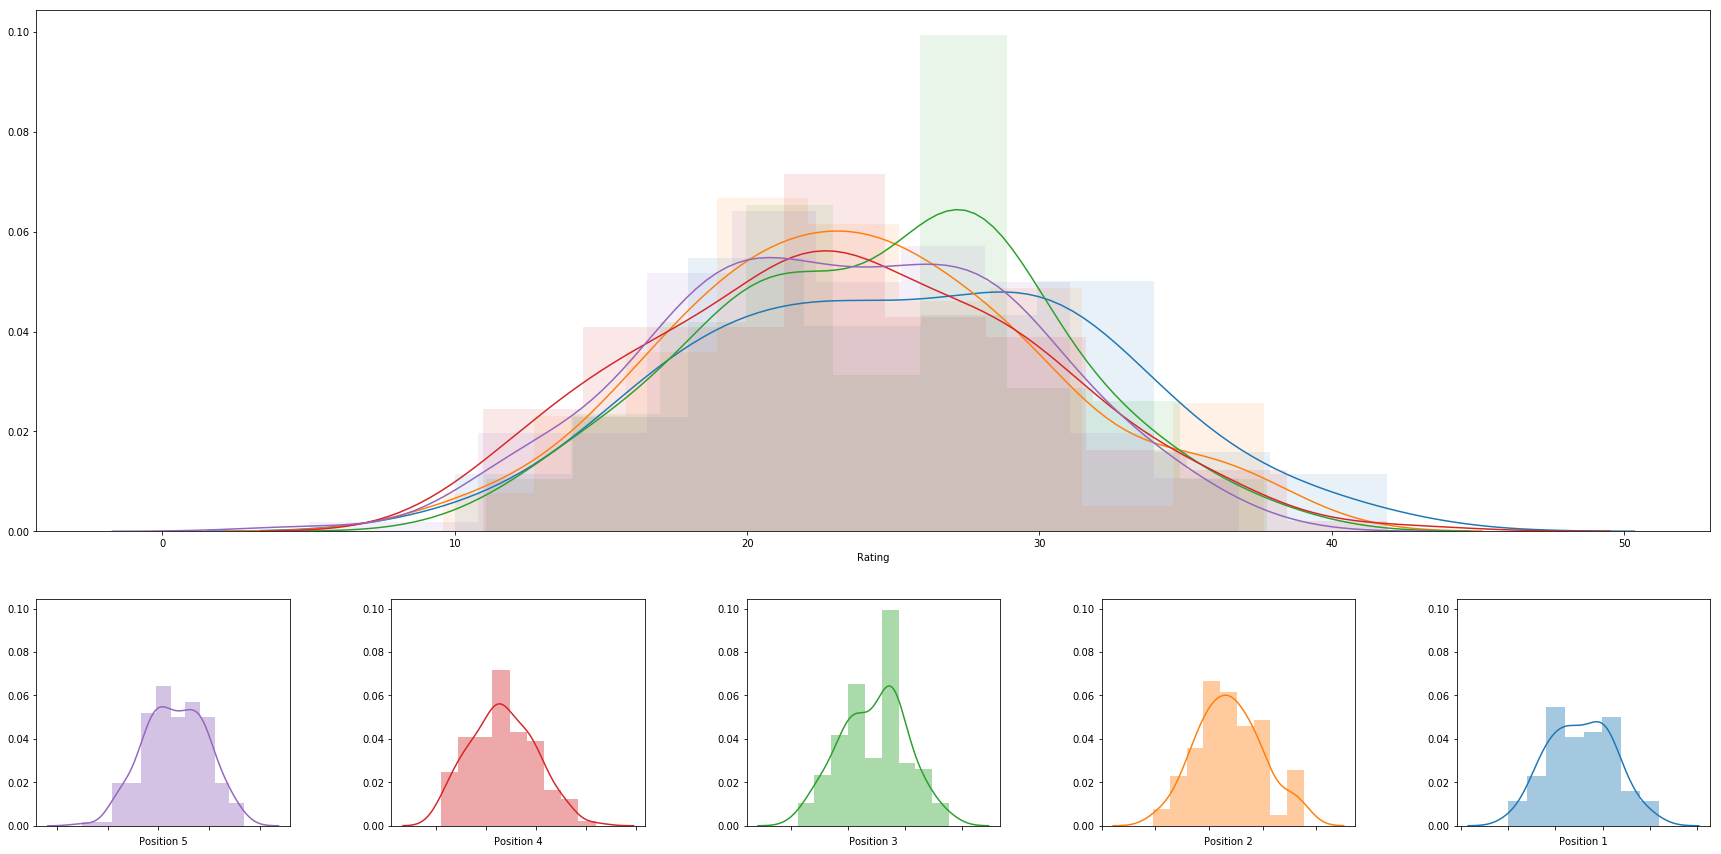

In [12]:
position_factor= [0 for i in range(5)]
df_match_history1 = create_ratings_from_matches(df, position_factor)
dd1 = plot_rating_distribution(df_match_history1)
tp1 = get_top_players(df_match_history1)

### Factor logic
- Athletes who have never played in competition for the season, shouldn't show up in ranking. As soon as they compete in a match, their initial rating is 25
- Athletes who have a win/loss record of less than 500 may have ratings lower than players who have never played in competition
- A 2.3 factor will be added to matchup results for Position 1 players to ensure that even if a match is lost, it does not result in loss of rating points
- No factor will be added to matchup results for Position 5 players.
- The remaing factors for positions 2, 3 and 4 shall be determined by limiting the overlap of the top ~25% of players in the position

## Introduce overlap

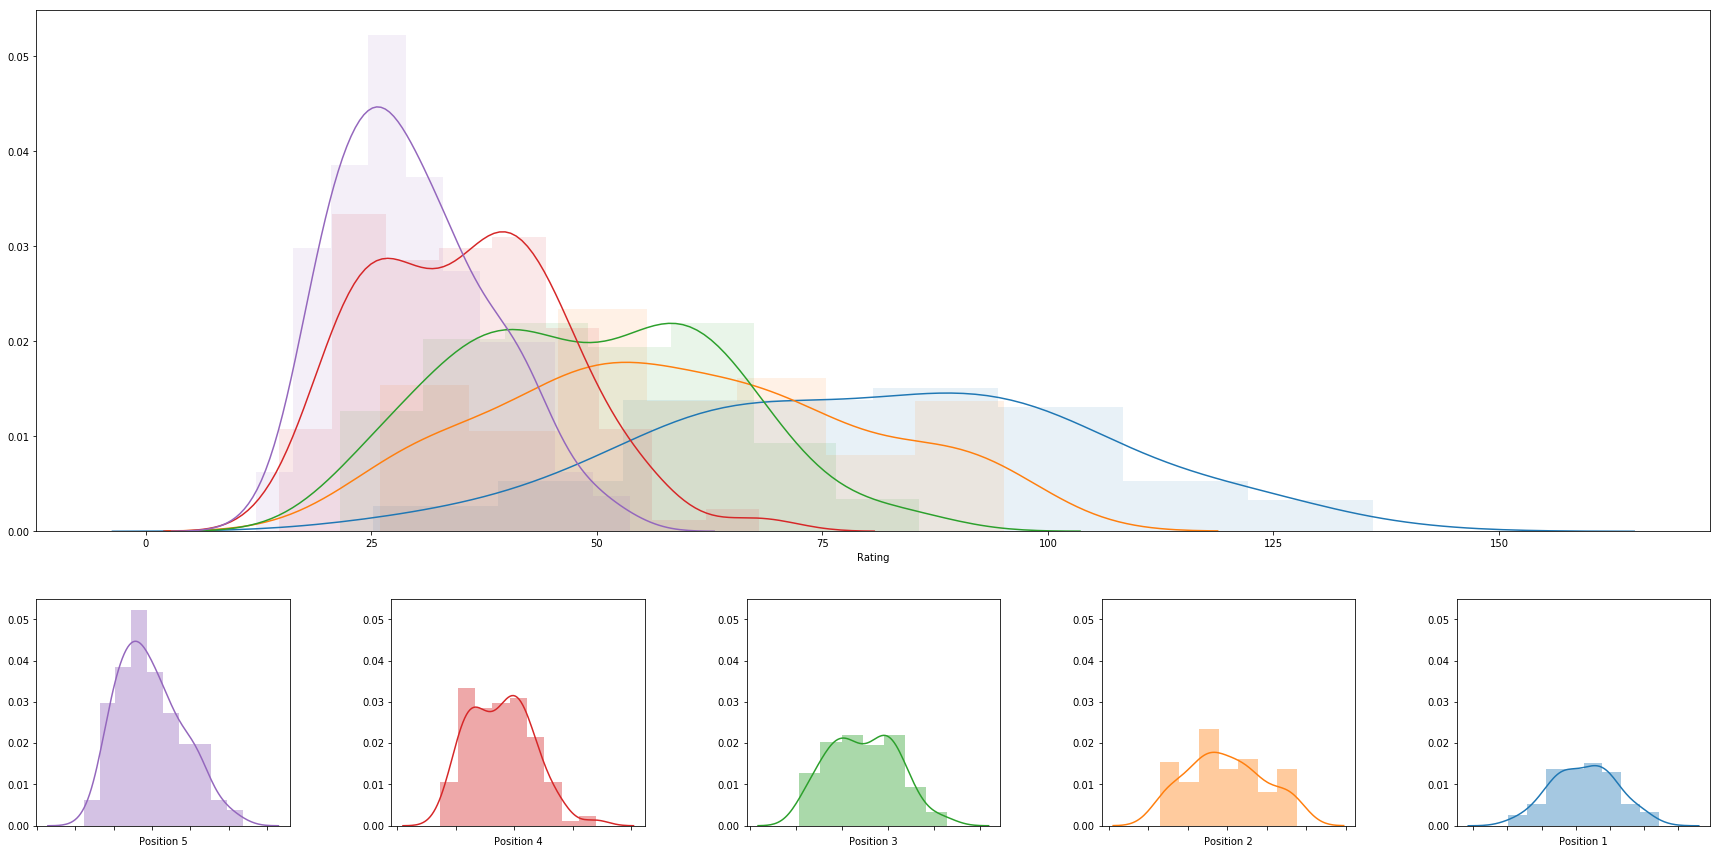

In [13]:
position_factor = [2.3,1.4,1,.25,0]
df_match_history2 = create_ratings_from_matches(df, position_factor)
dd2 = plot_rating_distribution(df_match_history2)
tp2 = get_top_players(df_match_history2)

## Introduce more overlap

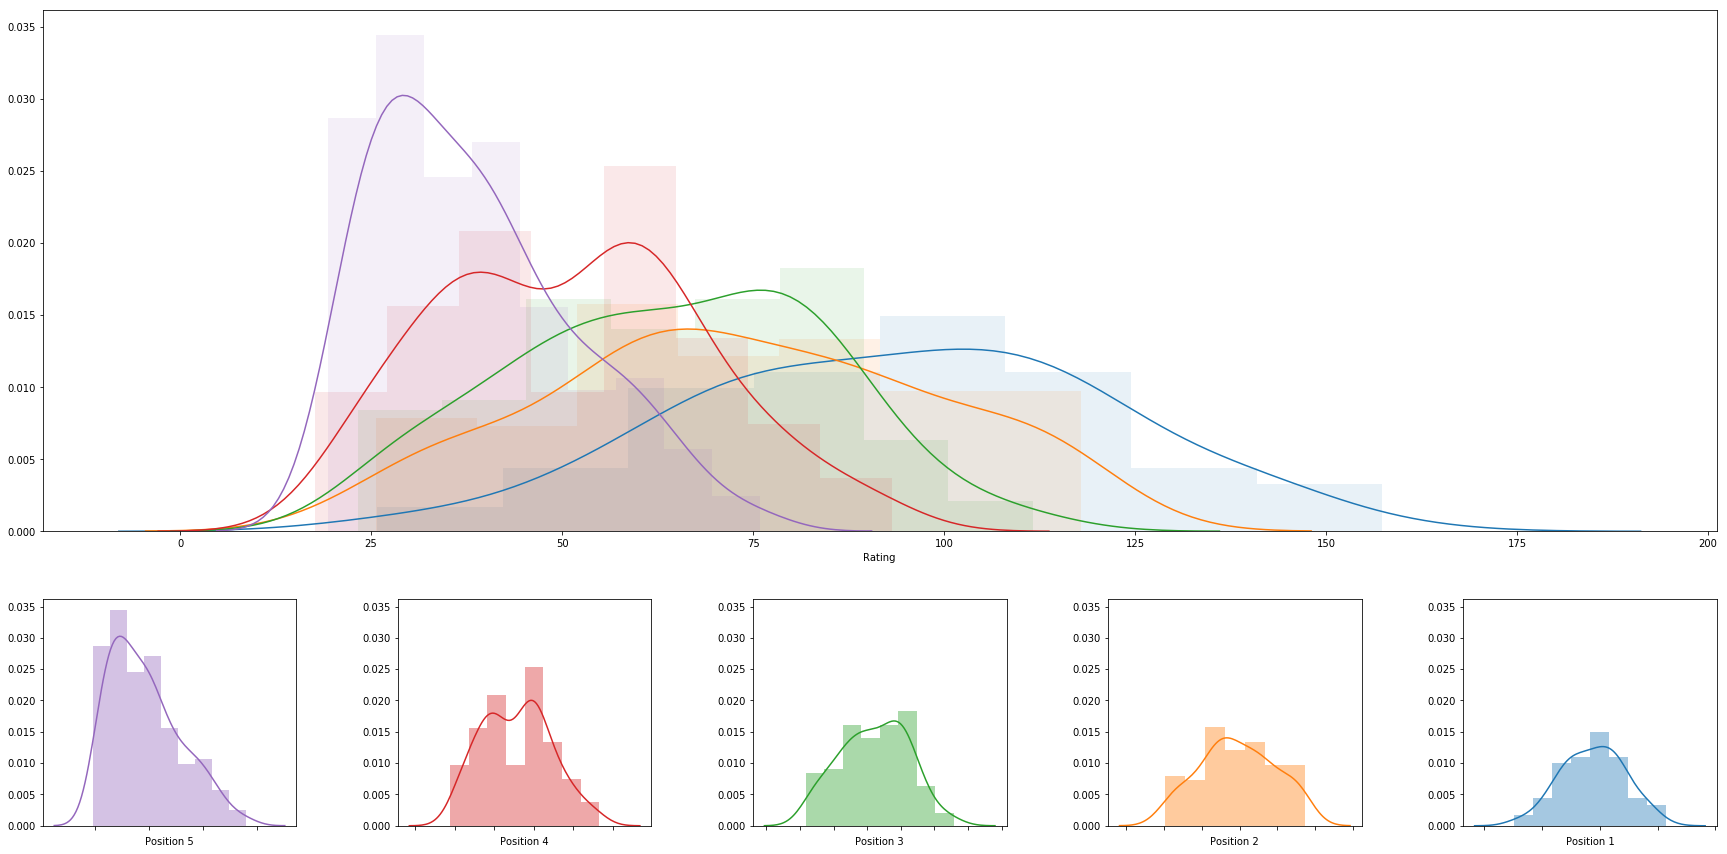

In [14]:
position_factor = [2.3,1.6,1.2,.75,0]
df_match_history3 = create_ratings_from_matches(df, position_factor)
dd3 = plot_rating_distribution(df_match_history3)
tp3 = get_top_players(df_match_history3)

In [ ]:
#Home field advantage, neutral and when close at 60/40

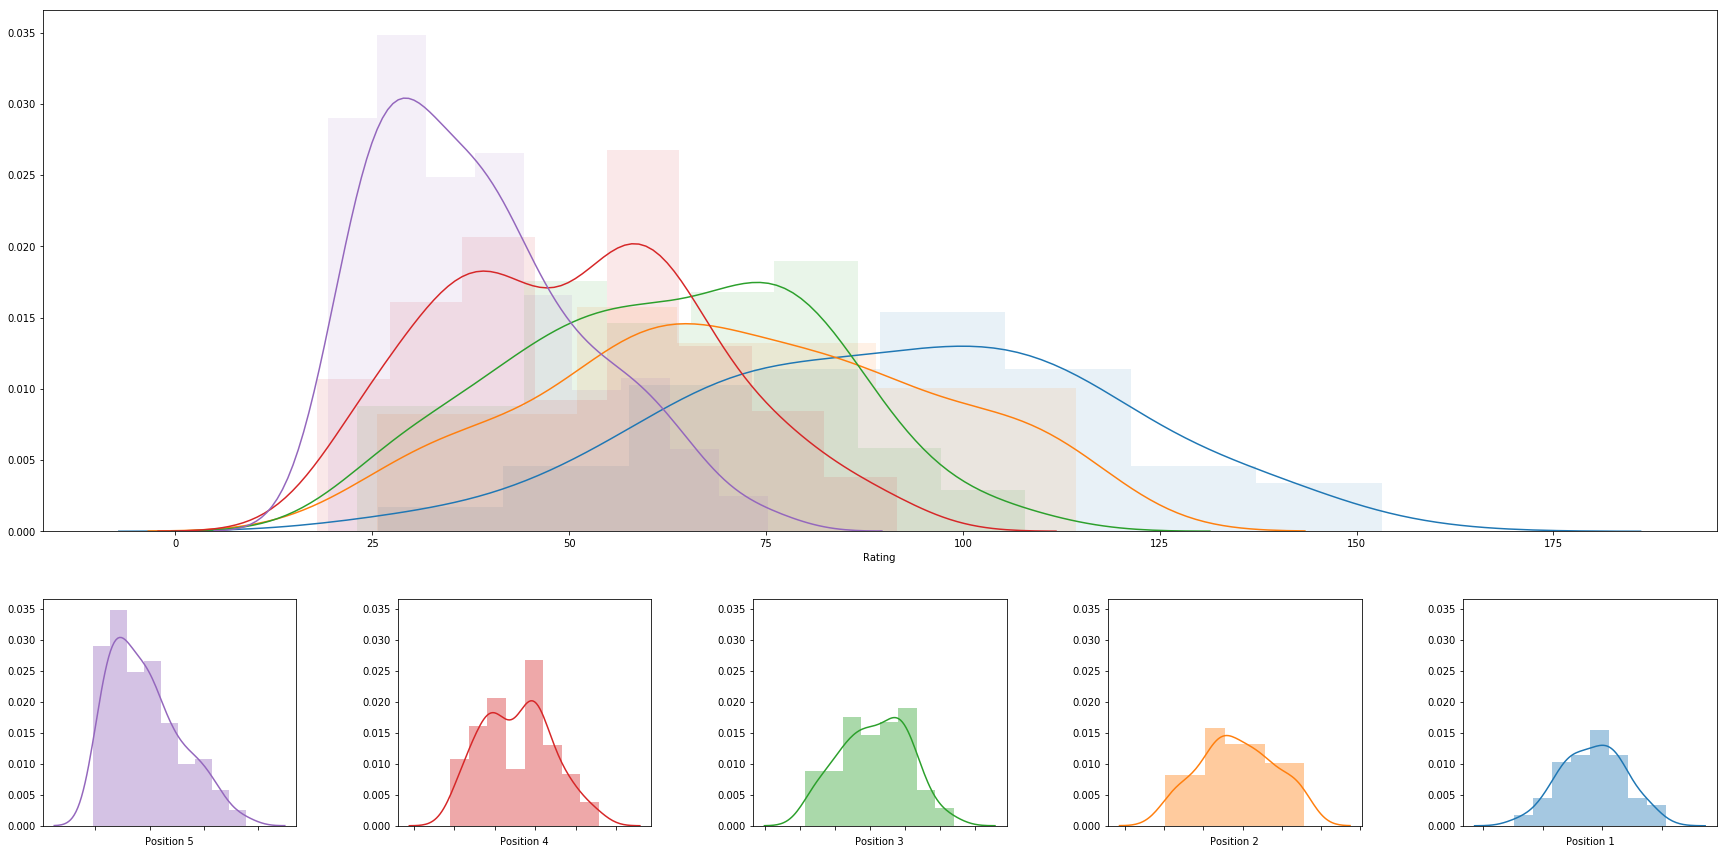

In [28]:
position_factor = [2.2,1.5,1.1,.75,0]
df_match_history4 = create_ratings_from_matches(df, position_factor)
dd4 = plot_rating_distribution(df_match_history4)
tp4 = get_top_players(df_match_history4)

In [29]:
view = get_top_players(df_match_history4)
view[view.name.isin([
                    "Torrey Van Winden",
                    "Tia Miric",
                    "Federica Frasca",
                    "Margherita Bianchin",
                    "Victoria Paranagua",
                    "Vanessa Freire",
                    "Claire Coppola",
                    "Kristen Nuss",
                    "Madeline Mertz",
                    "Kaylie Mchugh",
                    "Megan McNamara",
                    "Nicole McNamara",
                    "Emily Maglio",
                    "Ka'iwi Schucht",
                    "Abril Bustamante",
                    "Tina Graudina",
                    "Lily Justine",
                    "Sarah Sponcil",
                    "Deahna Kraft",
                    "Corinne Quiggle",
                    "Nele Barber",
                    "Molly Turner",
])]

,rank,name,college,division,rating,last match
0,1,Abril Bustamante,USC,DI,153.194999,2018-05-05
1,2,Ka'iwi Schucht,Hawaii,DI,140.021439,2018-05-06
2,3,Emily Maglio,Hawaii,DI,140.021439,2018-05-06
3,4,Megan McNamara,UCLA,DI,139.975159,2018-05-06
4,5,Nicole McNamara,UCLA,DI,139.975159,2018-05-06
5,6,Victoria Paranagua,Florida State,DI,137.520625,2018-05-05
6,7,Tina Graudina,USC,DI,136.029994,2018-05-05
7,8,Kristen Nuss,LSU,DI,133.308954,2018-05-04
8,9,Claire Coppola,LSU,DI,133.308954,2018-05-04
9,10,Vanessa Freire,Florida State,DI,129.650646,2018-05-05


In [30]:
view.head(40)

,rank,name,college,division,rating,last match
0,1,Abril Bustamante,USC,DI,153.194999,2018-05-05
1,2,Ka'iwi Schucht,Hawaii,DI,140.021439,2018-05-06
2,3,Emily Maglio,Hawaii,DI,140.021439,2018-05-06
3,4,Megan McNamara,UCLA,DI,139.975159,2018-05-06
4,5,Nicole McNamara,UCLA,DI,139.975159,2018-05-06
5,6,Victoria Paranagua,Florida State,DI,137.520625,2018-05-05
6,7,Tina Graudina,USC,DI,136.029994,2018-05-05
7,8,Kristen Nuss,LSU,DI,133.308954,2018-05-04
8,9,Claire Coppola,LSU,DI,133.308954,2018-05-04
9,10,Vanessa Freire,Florida State,DI,129.650646,2018-05-05


# Enter the name of a player to get their rating history

Jonny Baham
JONNY BAHAM
College: Arizona
Division: DI
Primary Position: 4
Last Rating:69.49291980070065


,compID,location,date,college,first_name,last_name,position,result,score,division,mu,sigma,name,Partner
0,855,"Tucson, Az",2018-02-25,Arizona,Jonny,Baham,4,1,"21-17,21-15",DI,29.312093,7.759734,Jonny Baham,Mia Mason (29.3120933313)
1,865,"Tucson, Az",2018-02-25,Arizona,Jonny,Baham,4,1,"21-18, 17-21, 15-7",DI,34.417476,7.188028,Jonny Baham,Mia Mason (34.4174758995)
2,887,"Tucson, Az",2018-03-02,Arizona,Jonny,Baham,5,1,"21-6, 21-9",DI,36.139502,6.944285,Jonny Baham,Caroline Cordes (34.0083782605)
3,891,"Tucson, AZ",2018-03-02,Arizona,Jonny,Baham,4,1,"21-15, 21-18",DI,38.599082,6.711704,Jonny Baham,Hailey Devlin (31.4884452097)
4,928,"Tucson, AZ",2018-03-03,Arizona,Jonny,Baham,5,0,"21-17, 21-16",DI,36.834619,6.307581,Jonny Baham,Caroline Cordes (28.1112816561)
5,993,"Long Beach, Ca",2018-03-06,Arizona,Jonny,Baham,5,0,"21-17, 21-12",DI,35.669263,6.020988,Jonny Baham,Stephany Purdue (22.4070574667)
6,1161,"Pismo Beach, Ca",2018-03-17,Arizona,Jonny,Baham,4,0,"21-13, 21-23, 17-15",DI,36.699402,5.856365,Jonny Baham,Brooke Burling (36.355402476)
7,1175,"Pismo Beach, Ca",2018-03-17,Arizona,Jonny,Baham,4,1,"21-16, 23-21",DI,40.832553,5.442727,Jonny Baham,Brooke Burling (40.1746502732)
8,1203,"Monterey, Ca",2018-03-18,Arizona,Jonny,Baham,5,1,"21-13, 21-9",DI,41.982914,5.337426,Jonny Baham,Brooke Burling (41.2839355954)
9,1204,"Monterey, Ca",2018-03-18,Arizona,Jonny,Baham,5,1,"21-18, 21-9",DI,44.243873,5.068907,Jonny Baham,Brooke Burling (43.3954879589)


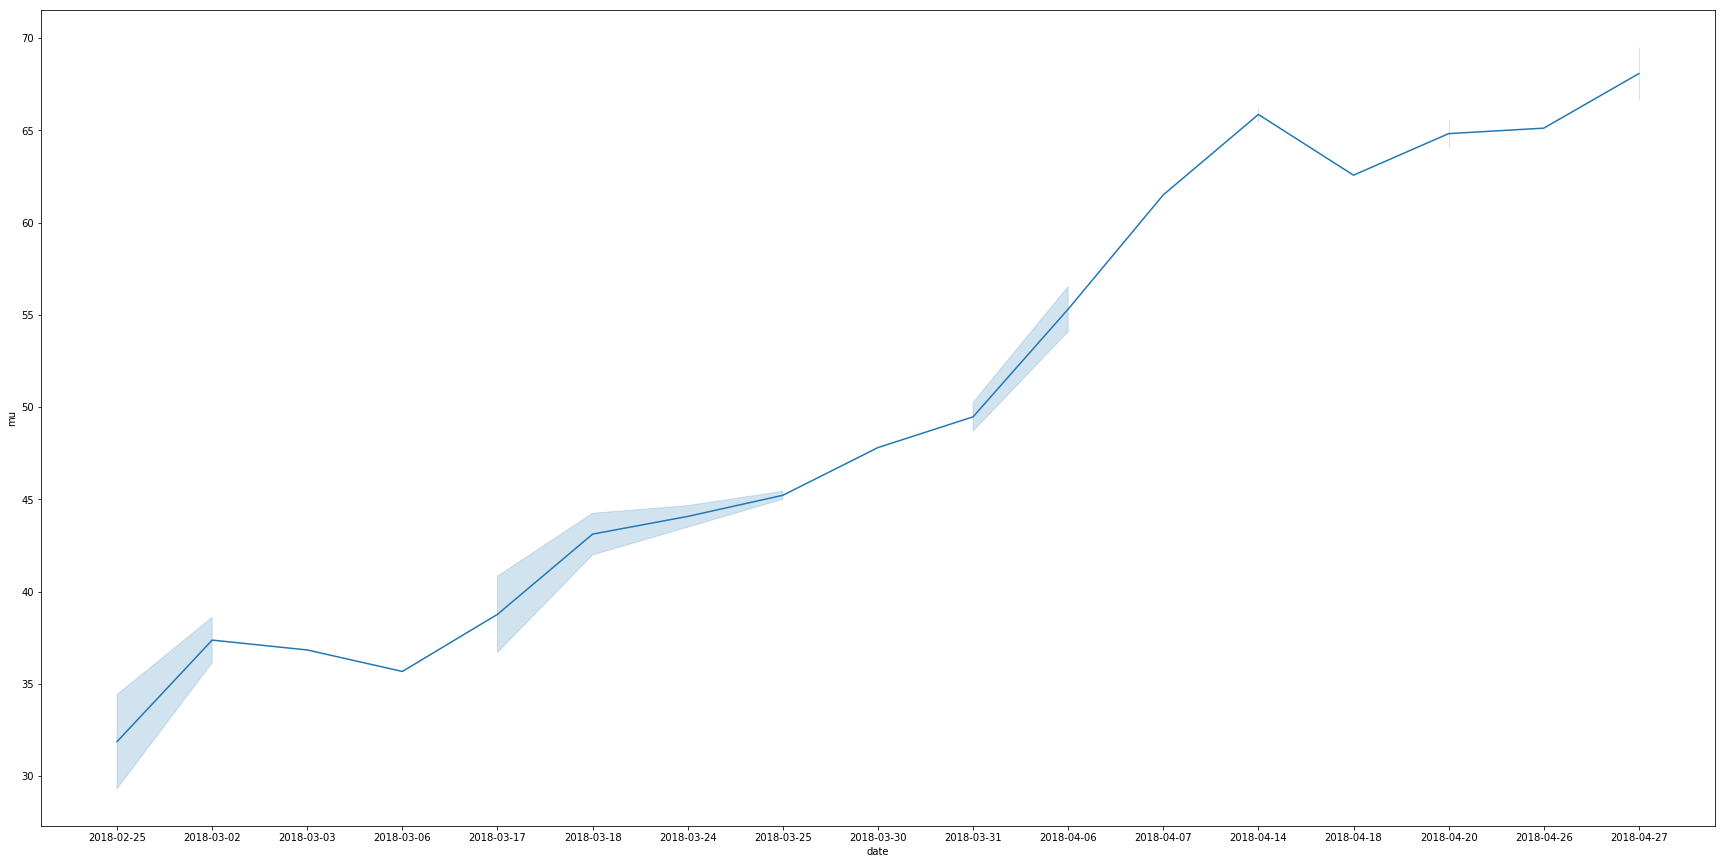

In [62]:
a = raw_input()
#a = 'Tina Graudina'
#a = 'Megan Muret'
#a = 'Haley Hallgren'
def get_player_rating_history(df, a):
    temp_df = df[df['name'] == a]
    print a.upper()
    print "College: " + temp_df['college'].unique()[-1]
    print "Division: " + temp_df['division'].unique()[-1]
    print "Primary Position: " + str(temp_df.groupby(['position'])['position'].count().sort_values(ascending=False).index[0])
    print "Last Rating:" + str(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0])
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(x="date", y="mu", data=temp_df)
    df_partner = pd.merge(df[df['name'] != a],temp_df, left_on=['compID', 'position', 'result'], right_on=['compID', 'position', 'result'] ) \
                    .groupby(['compID']) \
                    .first()
    df_partner.reset_index().set_index('compID')
    df_partner['Partner'] = df_partner['name_x']+' '+df_partner['mu_x'].apply(lambda x: '('+str(x)+ ')')
    df_partner = df_partner[['Partner']]
    df_summary = pd.merge(temp_df,df_partner, on='compID')
    #df_opponent = pd.merge(df_match_history2,temp_df, left_on=['compID', 'position'], right_on=['compID', 'position'] ) \
    #                .groupby(['compID']) \
    #                .first()
    #df_opponent

    return df_summary
get_player_rating_history(df_match_history4, a)

In [ ]:
#df_match_history.to_csv("Data/beachvb_history.csv", encoding='utf-8')

In [ ]:
#df_players.to_csv("Data/beachvb_player_ratings.csv", encoding='utf-8')

# Top Players By Position

In [55]:
a = 4
b = 1000
###get_top_players(df_match_history4, int(a)).head(int(b))

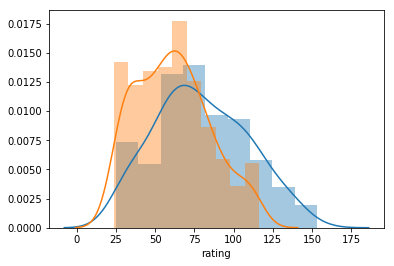

In [47]:
current_palette = sns.color_palette()

df1 = get_top_players(df_match_history4, 1)
sns.distplot(df1['rating'], color=current_palette[0])

df1 = get_top_players(df_match_history4, 2)
sns.distplot(df1['rating'], color=current_palette[1])

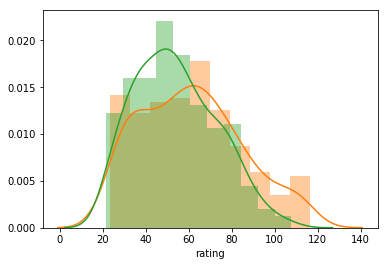

In [48]:
df1 = get_top_players(df_match_history4, 2)
sns.distplot(df1['rating'], color=current_palette[1])

df1 = get_top_players(df_match_history4, 3)
sns.distplot(df1['rating'], color=current_palette[2])

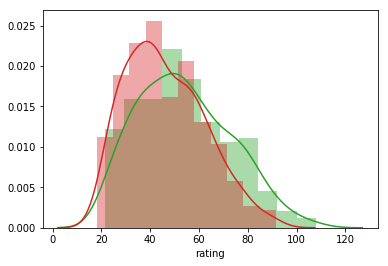

In [49]:
df1 = get_top_players(df_match_history4, 3)
sns.distplot(df1['rating'], color=current_palette[2])

df1 = get_top_players(df_match_history4, 4)
sns.distplot(df1['rating'], color=current_palette[3])

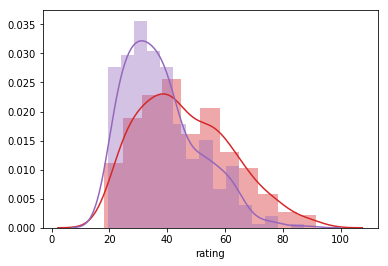

In [39]:
df1 = get_top_players(df_match_history4, 4)
sns.distplot(df1['rating'], color=current_palette[3])

df1 = get_top_players(df_match_history4, 5)
sns.distplot(df1['rating'], color=current_palette[4])